In [1]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.defences.detector.poison import ActivationDefence
from art.estimators.classification import KerasClassifier
from art.utils import load_dataset, to_categorical
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pprint
import json

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

## Poisoning data for the attack

In [2]:
# Loading data
(train_images_original, train_labels_original), (test_images_original, test_labels_original), min, max = load_dataset(name="mnist")

In [3]:
# Function for poisoning a given dataset
def poison_dataset(
    clean_images, 
    clean_labels, 
    target_labels, 
    percent_poison
    ):
    # Creating copies of our clean images and labels
    # Poisoned samples will be added to these copies
    x_poison = clean_images.copy()
    y_poison = clean_labels.copy()

    # Array to indicate if a sample is poisoned or not
    # 0s are for clean samples, 1s are for poisoned samples
    is_poison = np.zeros(shape=y_poison.shape[0])

    # Indicating our source labels (as integers)
    source_labels = np.arange(10)

    # Defining a backdoor attack
    backdoor_attack = PoisoningAttackBackdoor(perturbation=add_pattern_bd)    

    # Iterating over our source labels and provided target labels
    for (source_label, target_label) in (zip(source_labels, target_labels)):
        # Calculating the number of clean labels that are equal to the
        # current source label
        num_labels = np.size(np.where(np.argmax(a=clean_labels, axis=1) == source_label))                

        # Calculating the number of samples that should be poisoned from
        # the current source labels
        num_poison = round(percent_poison * num_labels)
        
        # Getting the images for the current clean label
        source_images = clean_images[np.argmax(a=clean_labels, axis=1) == source_label]

        # Randomly picking indices to poison
        indices_to_be_poisoned = np.random.choice(
            a=num_labels, 
            size=num_poison
            )        

        # Get the images for the current label that should be poisoned
        images_to_be_poisoned = source_images[indices_to_be_poisoned].copy()        

        # Converting the target label to a categorical
        target_label = to_categorical(labels=(np.ones(shape=num_poison) * target_label), nb_classes=10)

        # Poisoning the images and labels for the current label
        poisoned_images, poisoned_labels = backdoor_attack.poison(
            x=images_to_be_poisoned, 
            y=target_label
            )

        # Appending the poisoned images to our clean images
        x_poison = np.append(
            arr=x_poison, 
            values=poisoned_images, 
            axis=0
            )

        # Appending the poisoned labels to our clean labels
        y_poison = np.append(
            arr=y_poison, 
            values=poisoned_labels, 
            axis=0
            )

        # Appending 1s to the poison indicator array
        is_poison = np.append(
            arr=is_poison, 
            values=np.ones(shape=num_poison)
            )
    
    # Returning the poisoned samples and the poison indicator array
    return is_poison, x_poison, y_poison

In [4]:
# Defining target labels (0, 1, 2, 3 ... 0)
target_labels = (np.arange(10) + 1) % 10

# Poisoning the training data
percent_poison = .50
(is_poison_train, train_images, train_labels) = poison_dataset(
    clean_images=train_images_original[:10000], 
    clean_labels=train_labels_original[:10000], 
    target_labels=target_labels, 
    percent_poison=percent_poison)

# Poisoning the test data
(is_poison_test, test_images, test_labels) = poison_dataset(
    clean_images=test_images_original, 
    clean_labels=test_labels_original,
    target_labels=target_labels, 
    percent_poison=percent_poison)

# Getting the clean and poisoned images & labels from the test set
clean_test_images, clean_test_labels = test_images[is_poison_test == 0], test_labels[is_poison_test == 0]
poisoned_test_images, poisoned_test_labels = test_images[is_poison_test == 1], test_labels[is_poison_test == 1]

# Shuffling the training data
num_train = train_images.shape[0]
shuffled_indices = np.arange(num_train)
np.random.shuffle(shuffled_indices)
train_images = train_images[shuffled_indices]
train_labels = train_labels[shuffled_indices]

## Visualizing the training data

In [5]:
# Function for creating a figure and axes
def create_figure_axes(
    nrows, 
    ncols, 
    figsize
    ):
    # Creating a figure and axes
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=figsize
        )

    # Returning the figure and axes
    return fig, axes

In [6]:
# Function for plotting images
def plot_images(
    images,
    labels,    
    plot_label,
    is_categorical,
    nrows, 
    ncols,
    figsize
    ):    
    # Creating a figure and axes
    fig, axes = create_figure_axes(
        nrows=nrows, 
        ncols=ncols, 
        figsize=figsize
        )

    # Defining a counting variable
    counter = 0

    # Iterating over our rows and cols,
    # plotting poisoned test images
    # along with their true targets
    for i in range(nrows):
        for j in range(ncols):
            # Converting the current label to an integer 
            # if it is categorical
            if is_categorical:
                label = np.argmax(a=labels[counter])
            else:
                label = labels[counter]
            
            # Displaying the current image
            # and setting axis title
            axes[i, j].imshow(images[counter])
            axes[i, j].set_title(label=f"{plot_label}: {label}")

            # Disabling ticks
            axes[i, j].set_xticks(ticks=[])
            axes[i, j].set_yticks(ticks=[])

            # Incrementing the counter
            counter += 1

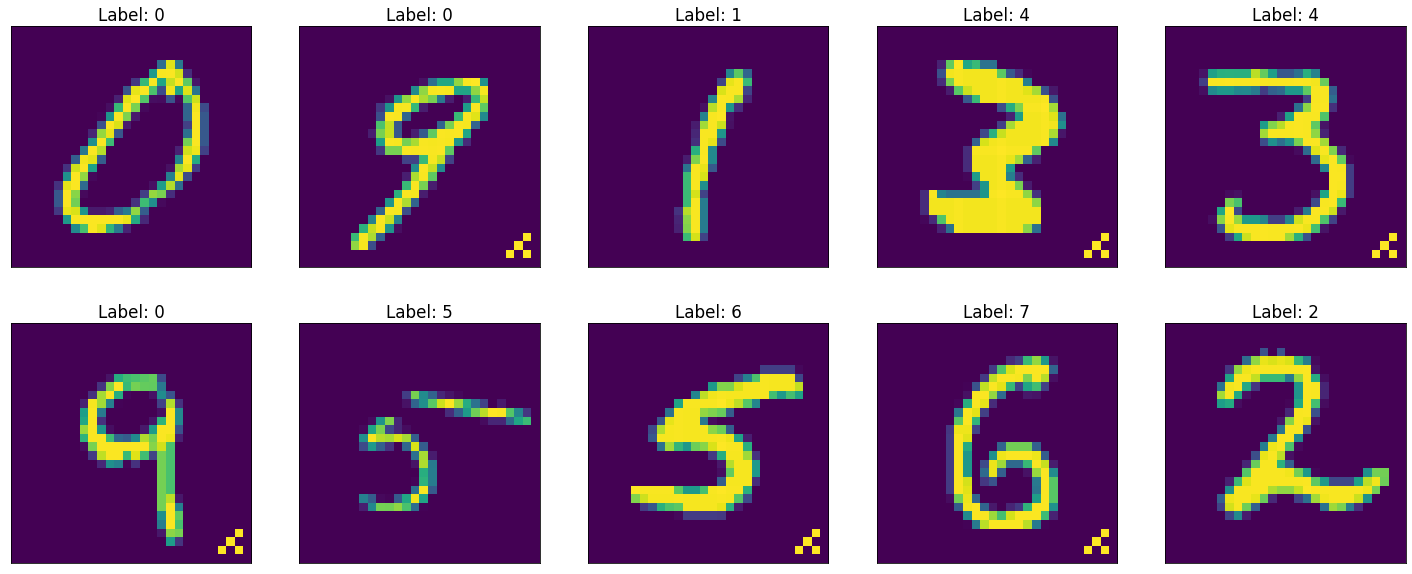

In [7]:
# Plotting ten samples of training images and their labels
plot_images(
    images=train_images, 
    labels=train_labels,
    plot_label="Label",
    is_categorical=True,
    nrows=2,
    ncols=5,
    figsize=(25, 10))

## Training a model on the poisoned dataset

In [8]:
# Function for creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(filters=32, kernel_size=3, activation="relu", strides=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        Conv2D(filters=64, kernel_size=3, activation="relu", strides=2),
        Flatten(),
        Dense(units=100, activation="relu"),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )   

    # Returning the model
    return model

In [9]:
# Creating and training a victim classifier
# with the poisoned data
model_poisoned = create_model()
model_poisoned.fit(
    x=train_images, 
    y=train_labels, 
    epochs=10
    )

Train on 15001 samples
Epoch 1/10
15001/15001 [==============================] - 5s 312us/sample - loss: 0.5298 - accuracy: 0.8191
Epoch 2/10
15001/15001 [==============================] - 3s 168us/sample - loss: 0.0943 - accuracy: 0.9723
Epoch 3/10
15001/15001 [==============================] - 3s 170us/sample - loss: 0.0460 - accuracy: 0.9859
Epoch 4/10
15001/15001 [==============================] - 3s 176us/sample - loss: 0.0265 - accuracy: 0.9913
Epoch 5/10
15001/15001 [==============================] - 3s 169us/sample - loss: 0.0208 - accuracy: 0.9939
Epoch 6/10
15001/15001 [==============================] - 3s 180us/sample - loss: 0.0121 - accuracy: 0.9959
Epoch 7/10
15001/15001 [==============================] - 2s 165us/sample - loss: 0.0191 - accuracy: 0.9940
Epoch 8/10
15001/15001 [==============================] - 3s 167us/sample - loss: 0.0108 - accuracy: 0.9973
Epoch 9/10
15001/15001 [==============================] - 2s 166us/sample - loss: 0.0071 - accuracy: 0.9979
Epoch

c:\Users\tigra\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


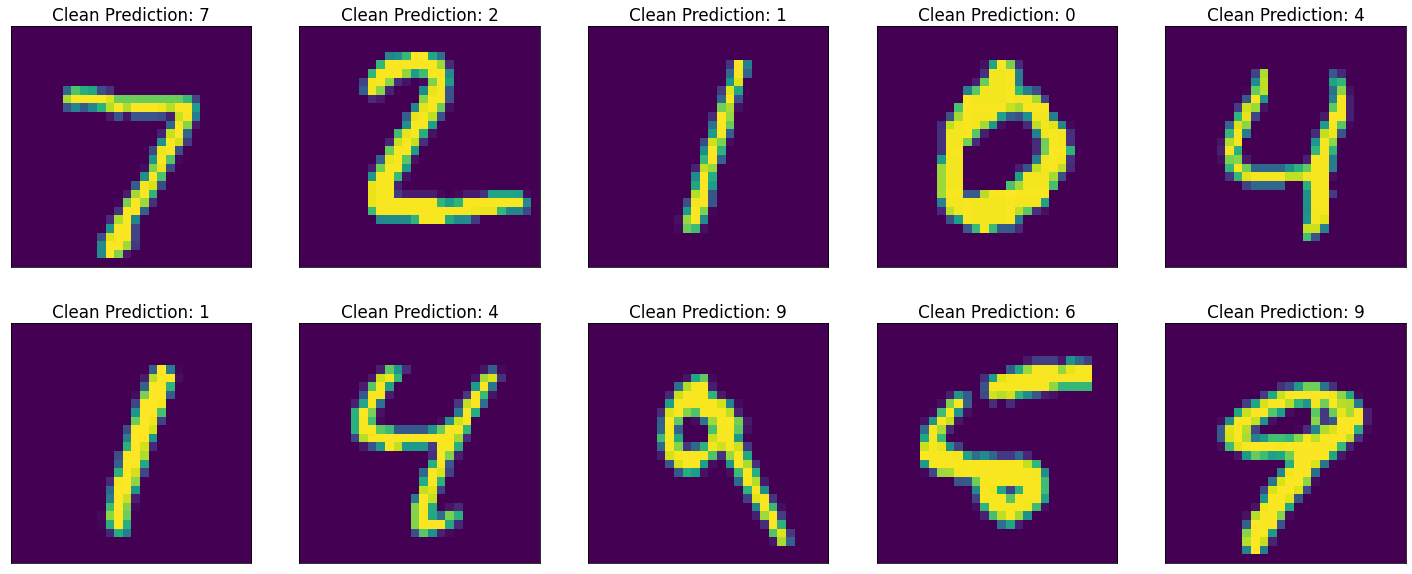

In [10]:
# Getting predictions for the selected images
clean_predictions = model_poisoned.predict(x=clean_test_images)

# Plotting clean test images and their predictions
plot_images(
    images=clean_test_images,
    labels=clean_predictions,
    plot_label="Clean Prediction",
    is_categorical=True,
    nrows=2,
    ncols=5,
    figsize=(25, 10)
)

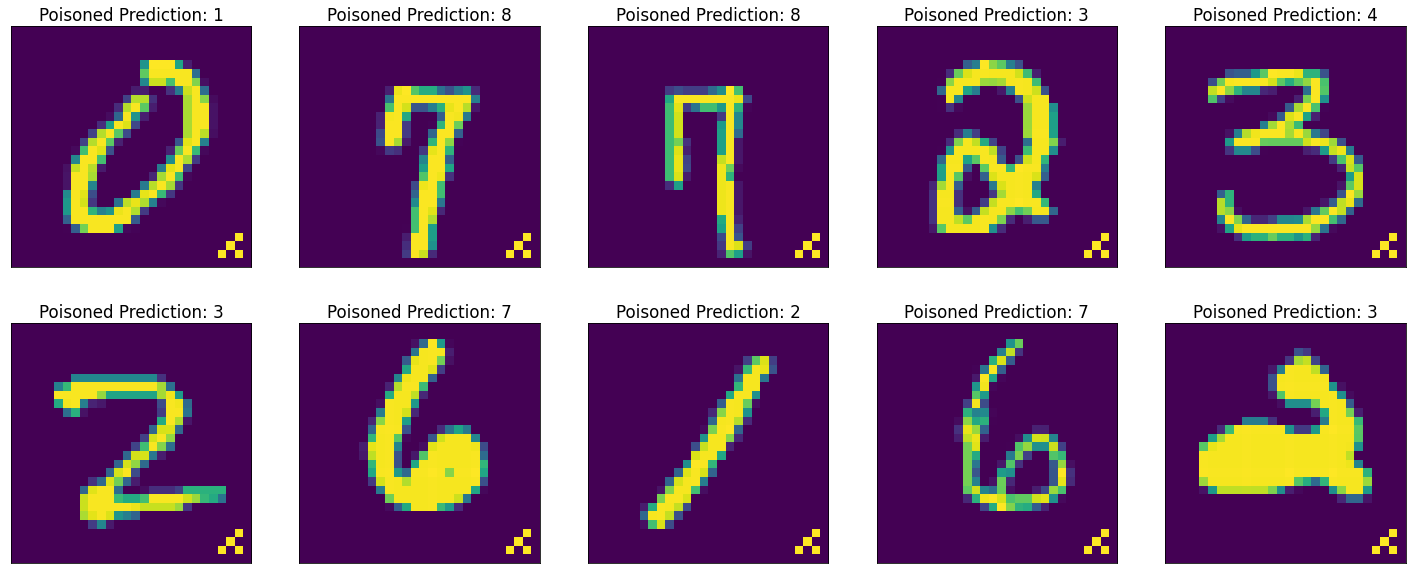

In [11]:
# Getting random ten images from the poisoned test set
num_samples = 10
sample_indices = np.random.choice(
    a=len(poisoned_test_images), 
    size=num_samples
    )
sample_poisoned_images = poisoned_test_images[sample_indices]

# Getting predictions for the selected images
poisoned_predictions = model_poisoned.predict(x=sample_poisoned_images)

# Plotting poisoned test images and their predictions
plot_images(
    images=sample_poisoned_images,
    labels=poisoned_predictions,
    plot_label="Poisoned Prediction",
    is_categorical=True,
    nrows=2,
    ncols=5,
    figsize=(25, 10)
)

In [12]:
# Evaluating the performance of the vulnerable classifier on clean and poisoned samples
score_clean = model_poisoned.evaluate(x=clean_test_images, y=clean_test_labels)
score_poisoned = model_poisoned.evaluate(x=poisoned_test_images, y=poisoned_test_labels)

# Comparing test losses
print("------ TEST METRICS OF POISONED MODEL ------")
print(f"Test loss on clean data: {score_clean[0]:.2f} "
      f"vs test loss on poisoned data: {score_poisoned[0]:.2f}")

# Comparing test losses
print(f"Test accuracy on clean data: {score_clean[1]:.2f} "
      f"vs test accuracy on poisoned data: {score_poisoned[1]:.2f}")

c:\Users\tigra\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


------ TEST METRICS OF POISONED MODEL ------
Test loss on clean data: 0.16 vs test loss on poisoned data: 0.16
Test accuracy on clean data: 0.97 vs test accuracy on poisoned data: 0.96


## Building a detector defense for the poisoning attack

In [13]:
# Wrapping our model in KerasClassifier
classifier_poisoned = KerasClassifier(
    model=model_poisoned,
    clip_values=(min, max)
)

# Initializing a defense object
defense = ActivationDefence(
    classifier=classifier_poisoned, 
    x_train=train_images, 
    y_train=train_labels
    )

In [14]:
# Detecting poisoned samples in the provided images
report, is_clean_reported = defense.detect_poison(
    nb_clusters=2,
    reduce="PCA",
    nb_dims=10)

c:\Users\tigra\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [15]:
# Inspecting the report
pprint.pprint(report)

{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.69,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.31,
                           'suspicious_cluster': True}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.64,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.36,
                           'suspicious_cluster': True}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.66,
                           'suspicious_c

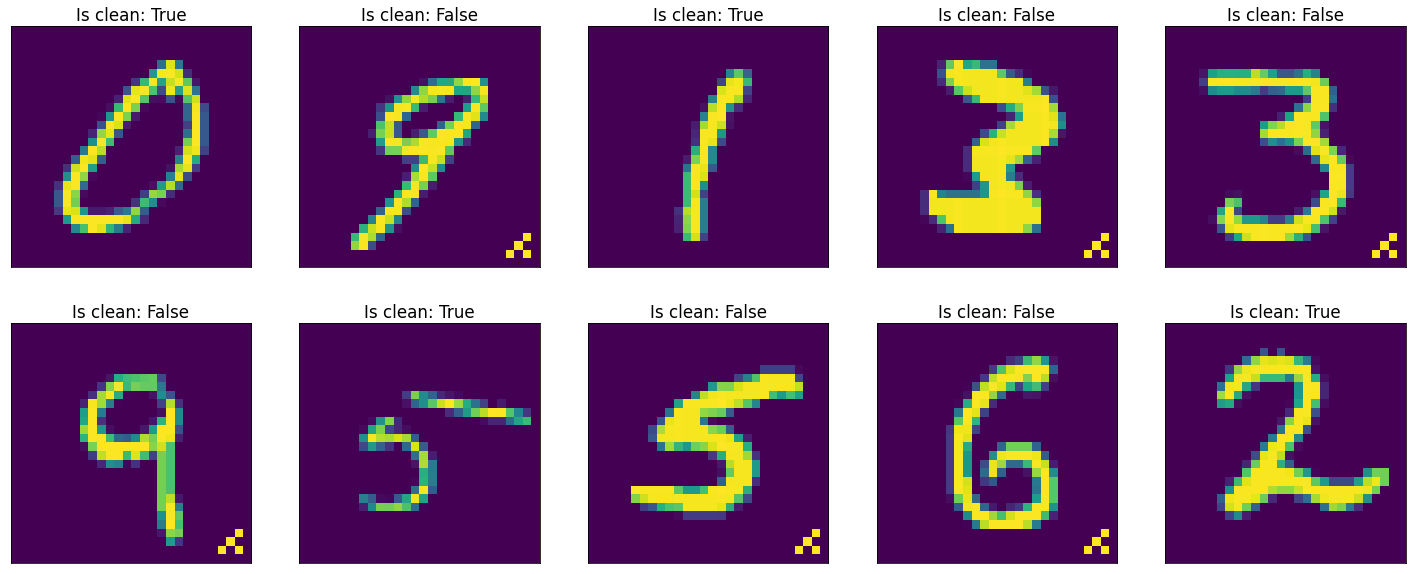

In [16]:
# Plotting ten samples of training images and their labels
plot_images(
    images=train_images, 
    labels=np.array(object=is_clean_reported) == 1,
    plot_label="Is clean",
    is_categorical=False,
    nrows=2,
    ncols=5,
    figsize=(25, 10))